<a href="https://colab.research.google.com/github/Gopi138942/Auto_Encoder/blob/main/mseloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

In [3]:
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

In [4]:
def prepare_train_validation_movielens_step1():
    rat = pd.read_csv('/content/ratings.csv')
    mov = pd.read_csv('/content/movies.csv')
    df_combined = pd.merge(rat, mov, on = 'movieId')
    print(rat.describe())
    ts = rat['timestamp'].quantile(0.98)
    train_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    validation_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    for i in range(len(rat)):
        if rat['timestamp'].iloc[i] <= ts:
            train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        else:
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        if i%10000 == 0:
            print(i, "Completed")
    print(len(train_ratings))
    print(len(validation_ratings))
    # Remove users in validation set those are not present in Training Set
    train_users = train_ratings['userId'].unique()
    users_not_in_train_set = []

    for i in range(1,611):
        if i in train_users:
            continue
        else:
            users_not_in_train_set.append(i)

    for i in users_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['userId']!=i]

    validation_ratings.reset_index(drop=True)

    print(len(train_ratings['movieId'].unique()))
    print(len(validation_ratings['movieId'].unique()))
    # Remove Movies that are not in the Train Set
    validation_movies = validation_ratings['movieId'].unique()
    train_movies = train_ratings['movieId'].unique()
    movies_not_in_train_set = []

    for i in validation_movies:
        if i in train_movies:
            continue
        else:
            movies_not_in_train_set.append(i)

    for i in movies_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['movieId']!=i]

    validation_ratings.reset_index(drop=True)
    print('Train Users: ', train_ratings['userId'].nunique())
    print('Validation Users: ',validation_ratings['userId'].nunique())
    print('Train Movies: ',train_ratings['movieId'].nunique())
    print('Validation Movies: ',validation_ratings['movieId'].nunique())
    train_ratings.to_csv("/content/train_ratings.csv")
    validation_ratings.to_csv("/content/validation_ratings.csv")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def prepare_traintest_movielens_step2():
    tr_ratings = pd.read_csv("/content/train_ratings.csv")
    val_ratings = pd.read_csv("/content/validation_ratings.csv")
    train_dataset = tr_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
    train_dataset.fillna(0, inplace=True)
    print(train_dataset.head(10))
    test_dataset = val_ratings.pivot_table(index='userId', columns='movieId', values='rating')
    test_dataset.fillna(0, inplace=True)
    print(test_dataset.head(10))
    train_dataset.to_csv('/content/train.csv')
    test_dataset.to_csv('/content/test.csv')

In [7]:
def get_traintestloaders():
    transformations = transforms.Compose([transforms.ToTensor()])
    train_dat = TrainDataset('/content/train.csv', transformations)
    test_dat = TestDataset('/content/test.csv', transformations)
    train_loader = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)
    test_loader = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)
    return train_loader, test_loader

In [21]:
class MSELoss_with_Mask(nn.Module):
    def __init__(self):
        super(MSELoss_with_Mask,self).__init__()

    def forward(self,inputs, targets):
        # Masking into a vector of 1's and 0's.
        mask = (targets!=0)
        mask = mask.float()
        # Actual number of ratings.
        # Take max to avoid division by zero while calculating loss.
        other = torch.Tensor([1.0])
        #other = other.cuda()
        number_ratings = torch.max(torch.sum(mask),other)
        error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
        loss = error.div(number_ratings)
        return loss[0]

In [9]:
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(9559, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
        )

        # Decoder layers - the final layer's output dimension should match the input dimension (9559)
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 9559),  # Output dimension should match input dimension
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device='cpu'):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs in train_loader:
            inputs = inputs.to(device).float()  # Ensure inputs are float32
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Calculate average training loss for the epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs in val_loader:
                inputs = inputs.to(device).float()  # Ensure inputs are float32
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (MMSE): {train_loss:.4f}, Validation Loss (MMSE): {val_loss:.4f}")

    return train_losses, val_losses

In [12]:
# Install CUDA if not already installed. Only run this cell once.
!apt-get install nvidia-cuda-toolkit


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [13]:
# Verify CUDA installation:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [14]:
prepare_train_validation_movielens_step1()

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
0 Completed


<ipython-input-4-cf043bd55686>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
<ipython-input-4-cf043bd55686>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])


10000 Completed
20000 Completed
30000 Completed
40000 Completed
50000 Completed
60000 Completed
70000 Completed
80000 Completed
90000 Completed
100000 Completed
98819
100836
9559
9608
Train Users:  595
Validation Users:  595
Train Movies:  9559
Validation Movies:  9559


In [15]:
prepare_traintest_movielens_step2()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6           0.0     4.0     5.0     3.0     5.0     4.0     4.0     3.0   
7           4.5     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8           0.0     4.0     0.0     0.0     0.0     0.0     0.0     0.0   
9           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  184349  184471  184791  185029  185031  185135  \
userId             

In [16]:
 # Determine the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [17]:
# Load data
train_loader, test_loader = get_traintestloaders()

In [18]:
model = AutoEncoder().to(device)

In [22]:

criterion = MSELoss_with_Mask().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Train the model and capture training and validation losses
train_losses, val_losses = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=40, device=device)


Epoch 1/40, Training Loss (MMSE): 11.4976, Validation Loss (MMSE): 8.1488
Epoch 2/40, Training Loss (MMSE): 8.3323, Validation Loss (MMSE): 7.1210
Epoch 3/40, Training Loss (MMSE): 5.6360, Validation Loss (MMSE): 4.6297
Epoch 4/40, Training Loss (MMSE): 5.7179, Validation Loss (MMSE): 3.7338
Epoch 5/40, Training Loss (MMSE): 3.4393, Validation Loss (MMSE): 2.9073
Epoch 6/40, Training Loss (MMSE): 2.8161, Validation Loss (MMSE): 2.5443
Epoch 7/40, Training Loss (MMSE): 2.3472, Validation Loss (MMSE): 2.2088
Epoch 8/40, Training Loss (MMSE): 2.1320, Validation Loss (MMSE): 1.9906
Epoch 9/40, Training Loss (MMSE): 2.0198, Validation Loss (MMSE): 2.1801
Epoch 10/40, Training Loss (MMSE): 1.9383, Validation Loss (MMSE): 1.5607
Epoch 11/40, Training Loss (MMSE): 1.6648, Validation Loss (MMSE): 2.1074
Epoch 12/40, Training Loss (MMSE): 1.8008, Validation Loss (MMSE): 1.2927
Epoch 13/40, Training Loss (MMSE): 1.5012, Validation Loss (MMSE): 1.7167
Epoch 14/40, Training Loss (MMSE): 2.0108, Val

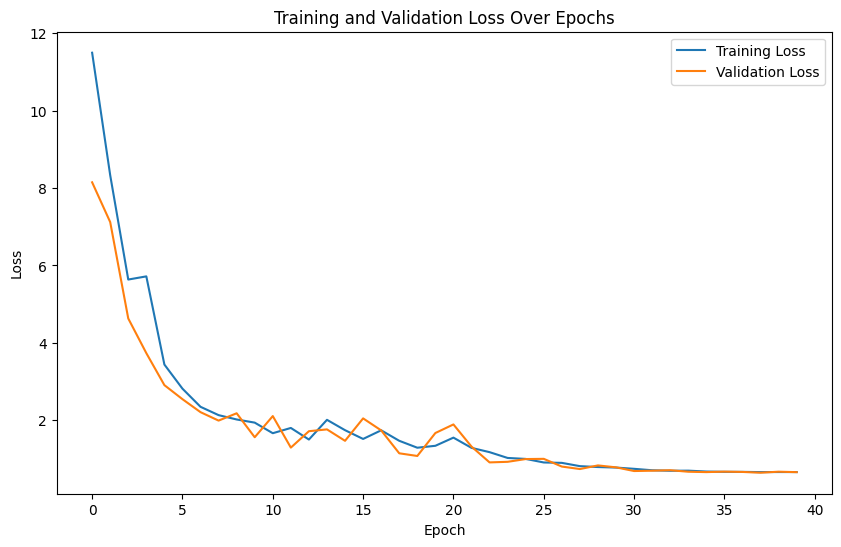

In [25]:
 # Plot the loss function for both the training and validation
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [27]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch

# Function to recommend items for a specific user
def recommend_for_user(model, user_ratings, top_n=5, device='cpu'):

    #Generate recommendations for a single user based on their existing ratings.

    # Move user_ratings to the correct device and ensure it's float32
    user_ratings = user_ratings.to(device).float().unsqueeze(0)  # Add batch dimension
    """
    Parameters:
    - model: Trained AutoEncoder model
    - user_ratings: Tensor of the user's ratings (with 0 for unrated items)
    - top_n: Number of top recommendations to return
    - device: Device on which the model runs ('cpu' or 'cuda')

    Returns:
    - List of indices representing the recommended items
    """
    # Pass the user ratings through the autoencoder to get reconstructed ratings
    model.eval()
    with torch.no_grad():
        reconstructed_ratings = model(user_ratings).squeeze(0)  # Remove batch dimension

    # Mask out already-rated items by setting their scores to a very low value
    mask = user_ratings.squeeze(0) == 0  # True for unrated items
    masked_ratings = reconstructed_ratings * mask  # Set rated items' scores to 0

    # Get indices of the top N recommendations
    recommended_indices = torch.argsort(masked_ratings, descending=True)[:top_n]

    return recommended_indices.tolist()


In [28]:
 # Generate recommendations for a sample user
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=9559, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=9559, bias=True)
  )
)

In [29]:
sample_user_ratings = next(iter(train_loader))  # Get a batch of user ratings from the training data


In [30]:
user_idx = 0  # Index of the user in the batch to generate recommendations for


In [32]:
# Get reconstructed ratings
with torch.no_grad():
    reconstructed_data = model(sample_user_ratings[user_idx].to(device).float())

print("Original ratings for the user:")
print(sample_user_ratings[user_idx])

print("\nReconstructed (predicted) ratings for the user:")
print(reconstructed_data)

Original ratings for the user:
tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

Reconstructed (predicted) ratings for the user:
tensor([3.2022, 2.9282, 2.6407,  ..., 3.0340, 2.8810, 0.6284])


In [31]:
recommendations = recommend_for_user(model, sample_user_ratings[user_idx], top_n=5, device=device)
print(f"Top recommendations for user {user_idx + 1}: {recommendations}")

Top recommendations for user 1: [4574, 4029, 6006, 8880, 5023]
